In [1]:
#Importing the required modules and general setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import iqr
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleAdiabatic
from galpy.df import quasiisothermaldf
from galpy.util.bovy_coords import *
import sys
sys.path.append('..')

#Importing qdf load data
samples_qdf = np.load('../mock_data/qdf/data/sampleV_at_(0.0,0.0,0.0)_epsilon=0.5_rect.npy')

#Setting up action angle and qdf instances
aA = actionAngleAdiabatic(pot=MWPotential2014,c=True)
qdf = quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aA,cutcounter=True)

#convert rectangular to cylindrical
R, phi, z = rect_to_cyl(samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
vR, vT, vz = rect_to_cyl_vec(samples_qdf[:,3], samples_qdf[:,4], samples_qdf[:,5], samples_qdf[:,0], samples_qdf[:,1], samples_qdf[:,2])
samples_qdf = np.stack((R, phi, z, vR, vT, vz), axis=1)


print('#stars', len(samples_qdf))
print('min/max/mean (R)', min(samples_qdf[:,0]), max(samples_qdf[:,0]), np.mean(samples_qdf[:,0]))
print('min/max/mean (phi)', min(samples_qdf[:,1]), max(samples_qdf[:,1]), np.mean(samples_qdf[:,1]))
print('min/max/mean (z)', min(samples_qdf[:,2]), max(samples_qdf[:,2]), np.mean(samples_qdf[:,2]))
print('min/max/mean (vR)', min(samples_qdf[:,3]), max(samples_qdf[:,3]), np.mean(samples_qdf[:,3]))
print('min/max/mean (vT)', min(samples_qdf[:,4]), max(samples_qdf[:,4]), np.mean(samples_qdf[:,4]))
print('min/max/mean (vz)', min(samples_qdf[:,5]), max(samples_qdf[:,5]), np.mean(samples_qdf[:,5]))
print(np.std(samples_qdf[:,0]), np.std(samples_qdf[:,1]), np.std(samples_qdf[:,2]), np.std(samples_qdf[:,3]), np.std(samples_qdf[:,4]), np.std(samples_qdf[:,5]))

c:\users\ayush\anaconda3\lib\site-packages\astropy\coordinates\sky_coordinate.py:1786: AstropyDeprecationWarning: Passing a frame as a positional argument is now deprecated, use the frame= keyword argument instead.
  "instead.", AstropyDeprecationWarning)

#stars 1699708
min/max/mean (R) 7.800911997788074 8.799620277350543 8.291940989763331
min/max/mean (phi) 3.0813469383936956 3.201835260171212 3.141300302894571
min/max/mean (z) -0.47224099228924643 0.5251864323212104 0.020554162071444157
min/max/mean (vR) -226.5417324492553 236.49705257869675 0.007393815901521288
min/max/mean (vT) 18.03771310630137 300.64400115120344 200.92571250021766
min/max/mean (vz) -78.63184750506196 79.49529776718326 -0.001518106057358567
0.19569240168043248 0.02471149215301263 0.16310598222016867 44.54007966376424 32.30194896834804 18.98694921618029


In [2]:
#Importing the required modules
import numpy as np
from sklearn.neighbors import KernelDensity

#Defining a KDE function to quickly compute probabilities for the data set
def generate_KDE(inputs, ker):
    """
    NAME:
        generate_KDE
    
    PURPOSE:
        Given an NxM matrix for inputs and one of six avaliable ker strings, 
        outputs a function `input_DKE` that treats the density estimate as a 
        black box function that can be sampled.
    
    INPUT:
        inputs (ndarray) = An NxM matrix where N is the number of data 
                           points and M is the number of parameters.
        ker (string) = One of the 6 avaliable kernel types (gaussian, 
                       tophat, epanechnikov, exponential, linear, cosine).
    
    OUTPUT:
        input_KDE (function) = A blackbox function for the density estimate
                               used for sampling data.
                               
    HISTORY:
        2018-07-15 - Updated - Ayush Pandhi
    """
    #Scaling velocities with z-score
    inputs_std = np.nanstd(inputs, axis=0)
    i1, i2, i3, i4, i5, i6 = np.mean(inputs, axis=0)
    inputs_mean = np.hstack((i1, i2, i3, i4, i5, i6))
    inputs = (inputs - inputs_mean)/inputs_std
    
    #Optimizing bandwidth in terms of Scott's Multivariate Rule of Thumb
    shape_string = str(inputs.shape)
    objects, parameters = shape_string.split(', ')
    N_string = objects[1:]
    N = int(N_string)
    bw = 5 * np.nanstd(inputs) * N ** (-1/10.)
    
    #Fit data points to selected kernel and bandwidth
    kde = KernelDensity(kernel=ker, bandwidth=bw).fit(inputs)  
    
    def input_KDE(samples):
        """
        NAME:
            input_KDE
    
        PURPOSE:
            Given a QxM matrix for samples, evaluates the blackbox density
            estimate function at those points to output a 1xQ array of 
            density values.
    
        INPUT:
            samples (ndarray) = A QxM matrix where Q is the number of points 
                                at which the kde is being evaluated and M is 
                                the number of parameters.
                                
        OUTPUT:
            dens (ndarray) = A 1xQ array of density values for Q data points.
                               
        HISTORY:
            2018-07-15 - Updated - Ayush Pandhi
        """
        #To correct the type of information from other functions into acceptable input
        #samples = np.array([samples])
        
        #Scaling samples with standard deviation
        samples = (samples - inputs_mean)/inputs_std
        
        #Get the log density for selected samples and apply exponential to get normal probabilities
        log_dens = kde.score_samples(samples)
        dens = np.exp(log_dens)
        
        #Return a 1xQ array of normal probabilities for the selected sample
        return dens
    
    #Return a black box function for sampling
    return input_KDE

In [3]:
#Generate kde for 6D qdf inputs
kde_qdf_epanechnikov = generate_KDE(samples_qdf, 'epanechnikov')

In [4]:
#Creating sample points for each parameter changing
N = 1000

#Mean of each parameter as a Nx1 object
mean_R = np.ones((N, 1))*np.mean(samples_qdf[:,0])
mean_phi = np.ones((N, 1))*np.mean(samples_qdf[:,1])
mean_z = np.ones((N, 1))*np.mean(samples_qdf[:,2])
mean_vR = np.ones((N, 1))*np.mean(samples_qdf[:,3])
mean_vT = np.ones((N, 1))*np.mean(samples_qdf[:,4])
mean_vz = np.ones((N, 1))*np.mean(samples_qdf[:,5])

#Generating Nx6 sample points for each varying parameter
#For variable R
R_points = np.linspace(min(samples_qdf[:,0]), max(samples_qdf[:,0]), N)
R_points = R_points.reshape(-1, 1)
sample_R = np.hstack((R_points, mean_phi, mean_z, mean_vR, mean_vT, mean_vz))

#For variable phi
phi_points = np.linspace(min(samples_qdf[:,1]), max(samples_qdf[:,1]), N)
phi_points = phi_points.reshape(-1, 1)
sample_phi = np.hstack((mean_R, phi_points, mean_z, mean_vR, mean_vT, mean_vz))
                 
#For variable z
z_points = np.linspace(min(samples_qdf[:,2]), max(samples_qdf[:,2]), N)
z_points = z_points.reshape(-1, 1)
sample_z = np.hstack((mean_R, mean_phi, z_points, mean_vR, mean_vT, mean_vz))
                 
#For variable vR
vR_points = np.linspace(min(samples_qdf[:,3]), max(samples_qdf[:,3]), N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(min(samples_qdf[:,4]), max(samples_qdf[:,4]), N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(min(samples_qdf[:,5]), max(samples_qdf[:,5]), N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

Variable R at Scotts bw


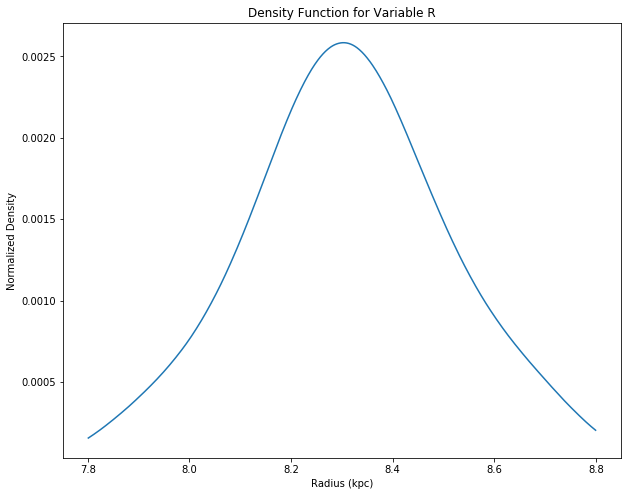

In [9]:
#Variable R plot
print('Variable R at Scotts bw')
plt.figure(figsize = (10, 8))
Rplot_epanechnikov = kde_qdf_epanechnikov(sample_R)
plt.plot(R_points, Rplot_epanechnikov)
plt.xlabel('Radius (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable R')
plt.savefig('zscore_cyl_variable_R')
plt.show()

Variable phi at Scotts bw


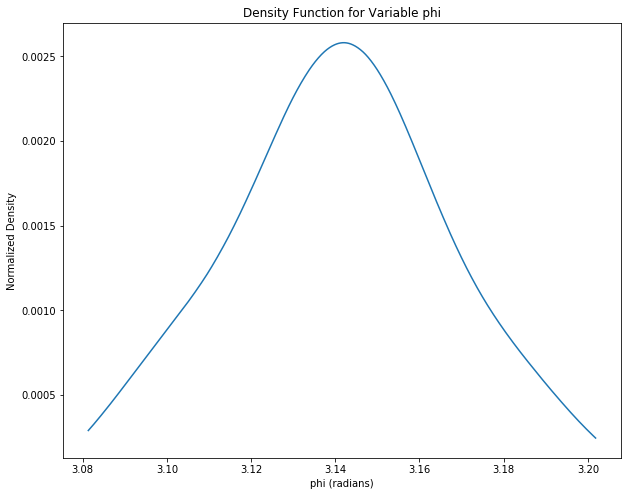

In [10]:
#Variable phi plot
print('Variable phi at Scotts bw')
plt.figure(figsize = (10, 8))
phiplot_epanechnikov = kde_qdf_epanechnikov(sample_phi)
plt.plot(phi_points, phiplot_epanechnikov)
plt.xlabel('phi (radians)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable phi')
plt.savefig('zscore_cyl_variable_phi')
plt.show()

Variable z at Scotts bw


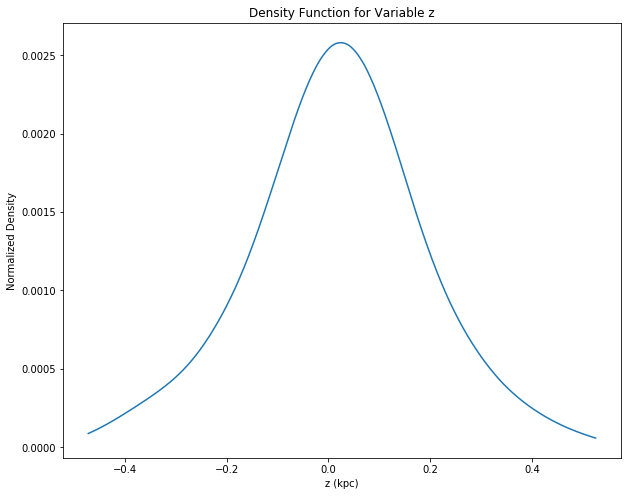

In [11]:
#Variable z plot
print('Variable z at Scotts bw')
plt.figure(figsize = (10, 8))
zplot_epanechnikov = kde_qdf_epanechnikov(sample_z)
plt.plot(z_points, zplot_epanechnikov)
plt.xlabel('z (kpc)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable z')
plt.savefig('zscore_cyl_variable_z')
plt.show()

Variable vR at Scotts bw


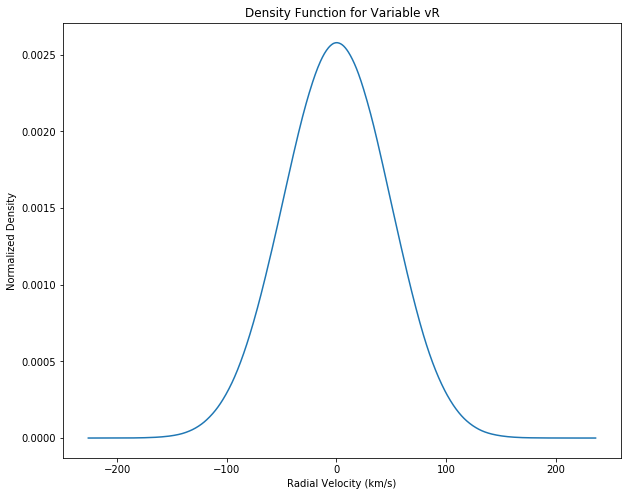

In [12]:
#Variable vR plot
print('Variable vR at Scotts bw')
plt.figure(figsize = (10, 8))
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov)
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vR')
plt.savefig('zscore_cyl_variable_vR')
plt.show()

Variable vT at Scotts bw


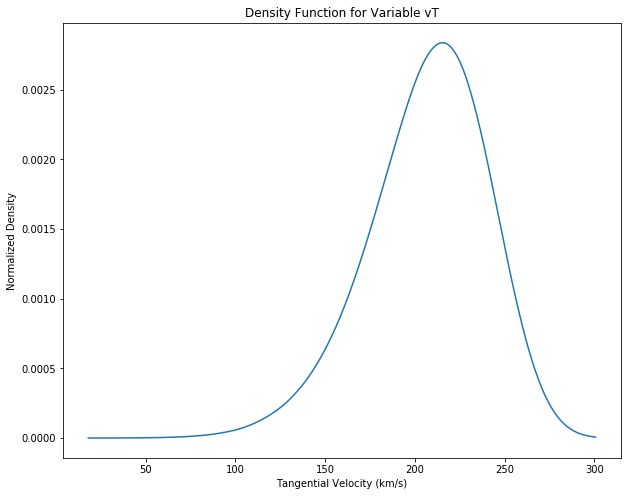

In [13]:
#Variable vT plot
print('Variable vT at Scotts bw')
plt.figure(figsize = (10, 8))
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov)
plt.xlabel('Tangential Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vT')
plt.savefig('zscore_cyl_variable_vT')
plt.show()

Variable vz at Scotts bw


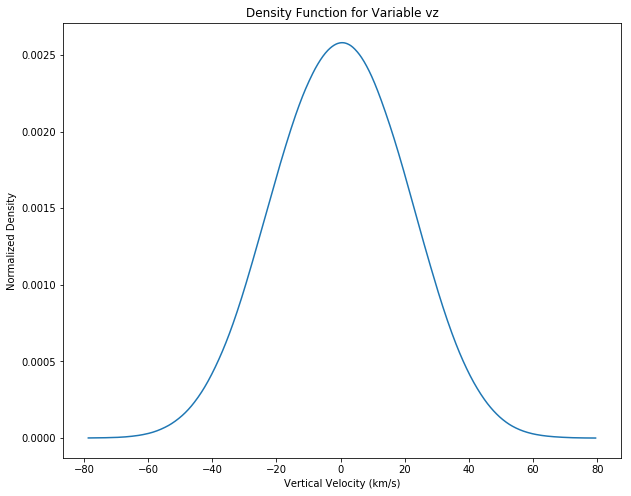

In [14]:
#Variable vz plot
print('Variable vz at Scotts bw')
plt.figure(figsize = (10, 8))
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov)
plt.xlabel('Vertical Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Density Function for Variable vz')
plt.savefig('zscore_cyl_variable_vz')
plt.show()

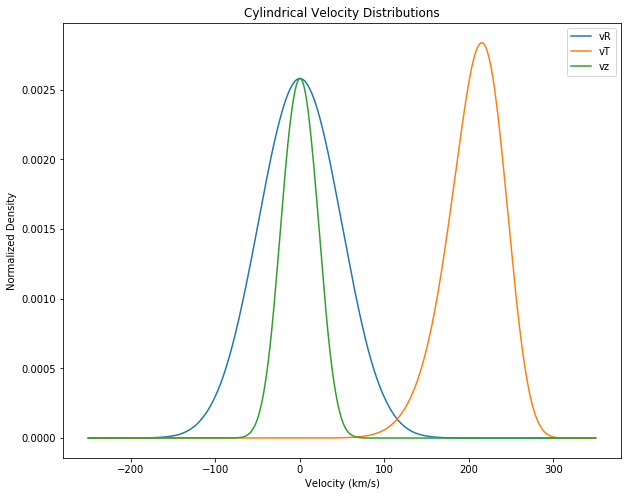

In [15]:
#For variable vR
vR_points = np.linspace(-250, 350, N)
vR_points = vR_points.reshape(-1, 1)
sample_vR = np.hstack((mean_R, mean_phi, mean_z, vR_points, mean_vT, mean_vz))

#For variable vT
vT_points = np.linspace(-250, 350, N)
vT_points = vT_points.reshape(-1, 1)
sample_vT = np.hstack((mean_R, mean_phi, mean_z, mean_vR, vT_points, mean_vz))
                 
#For variable vz
vz_points = np.linspace(-250, 350, N)
vz_points = vz_points.reshape(-1, 1)
sample_vz = np.hstack((mean_R, mean_phi, mean_z, mean_vR, mean_vT, vz_points))

#Overplotting velocities
plt.figure(figsize = (10, 8))

#Epanechnikov, vR, Scotts
vRplot_epanechnikov = kde_qdf_epanechnikov(sample_vR)
plt.plot(vR_points, vRplot_epanechnikov, label='vR')

#Epanechnikov, vT, Scotts
vTplot_epanechnikov = kde_qdf_epanechnikov(sample_vT)
plt.plot(vT_points, vTplot_epanechnikov, label='vT')

#Epanechnikov, vz, Scotts
vzplot_epanechnikov = kde_qdf_epanechnikov(sample_vz)
plt.plot(vz_points, vzplot_epanechnikov, label='vz')

#Show plot
plt.xlabel('Velocity (km/s)')
plt.ylabel('Normalized Density')
plt.title('Cylindrical Velocity Distributions')
plt.legend()
plt.savefig('zscore_cyl_velocity_distribution')
plt.show()

In [5]:
from scipy.integrate import tplquad
import time

#Input values for R
R_input = np.linspace(7, 9, 100)

# -----------------
# Integrate over R
# -----------------

def kde_qdf_cyl_R(vT, vz, vR, R, phi, z):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_R(kde_qdf_epanechnikov, R): #bounds of vT = [0, 300], bounds of vz = [-100, 100], bounds of vR = [-200, 200]
    print ("Evaluating at R =", R)
    return tplquad(kde_qdf_cyl_R, 0., 300., -100., 100., -200., 200., args=([R, 3.14, 0.]), epsabs=0.1)  # args=(R, phi, z)

R_output = np.ones([100])


print("With phi, z = 3.14, 0., integrating over vT from [0, 300], vz from [-100, 100] and vR from [-200, 200]")
print("KDE Evaluations along R from [7, 9] kpc over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for r in np.nditer(R_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    R_output[counter - 1], error = integrate_over_R(kde_qdf_epanechnikov, r)
    print("Value:", R_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()

With phi, z = 3.14, 0., integrating over vT from [0, 300], vz from [-100, 100] and vR from [-200, 200]
KDE Evaluations along R from [7, 9] kpc over 100 subintervals.

Evaluation: 1
Evaluating at R = 7.0
Value: 0.0
Time to integrate: 8.46s
Time elapsed: 0.14 min

Evaluation: 2
Evaluating at R = 7.02020202020202
Value: 0.0
Time to integrate: 8.37s
Time elapsed: 0.28 min

Evaluation: 3
Evaluating at R = 7.040404040404041
Value: 0.0
Time to integrate: 7.84s
Time elapsed: 0.41 min

Evaluation: 4
Evaluating at R = 7.0606060606060606
Value: 0.0
Time to integrate: 7.73s
Time elapsed: 0.54 min

Evaluation: 5
Evaluating at R = 7.08080808080808
Value: 0.0
Time to integrate: 7.97s
Time elapsed: 0.67 min

Evaluation: 6
Evaluating at R = 7.101010101010101
Value: 0.0
Time to integrate: 8.27s
Time elapsed: 0.81 min

Evaluation: 7
Evaluating at R = 7.121212121212121
Value: 0.0
Time to integrate: 8.03s
Time elapsed: 0.94 min

Evaluation: 8
Evaluating at R = 7.141414141414142
Value: 0.0
Time to integrate

Value: 307.98891789590266
Time to integrate: 86.61s
Time elapsed: 117.37 min

Evaluation: 69
Evaluating at R = 8.373737373737374
Value: 294.61628041097157
Time to integrate: 447.3s
Time elapsed: 124.83 min

Evaluation: 70
Evaluating at R = 8.393939393939394
Value: 278.40347103415394
Time to integrate: 210.71s
Time elapsed: 128.34 min

Evaluation: 71
Evaluating at R = 8.414141414141415
Value: 260.14726441026846
Time to integrate: 362.52s
Time elapsed: 134.38 min

Evaluation: 72
Evaluating at R = 8.434343434343434
Value: 240.62528766987936
Time to integrate: 152.02s
Time elapsed: 136.91 min

Evaluation: 73
Evaluating at R = 8.454545454545455
Value: 220.5851019888945
Time to integrate: 129.29s
Time elapsed: 139.07 min

Evaluation: 74
Evaluating at R = 8.474747474747474
Value: 200.7365749107234
Time to integrate: 366.68s
Time elapsed: 145.18 min

Evaluation: 75
Evaluating at R = 8.494949494949495
Value: 181.59610448539107
Time to integrate: 36.4s
Time elapsed: 145.79 min

Evaluation: 76
Ev

In [6]:
#Input values for z
z_input = np.linspace(-1, 1, 100)

# -----------------
# Integrate over z
# -----------------

def kde_qdf_cyl_z(vT, vz, vR, R, phi, z):
    evaluation = kde_qdf_epanechnikov(np.array([[R, phi, z, vR, vT, vz]]))
    return evaluation

def integrate_over_z(kde_qdf_epanechnikov, z): #bounds of vT = [0, 300], bounds of vz = [-100, 100], bounds of vR = [-200, 200]
    print ("Evaluating at z =", z)
    return tplquad(kde_qdf_cyl_z, 0., 300., -100., 100., -200., 200., args=([8.3, 3.14, z]), epsabs=0.1)  # args=(R, phi, z)

z_output = np.ones([100])


print("With phi, R = 3.14, 8.3, integrating over vT from [0, 300], vz from [-100, 100] and vR from [-200, 200]")
print("KDE Evaluations along z from [-1, 1] kpc over 100 subintervals.")
print()

counter = 0
start_overall = time.time()

for zstep in np.nditer(z_input):
    counter += 1
    print("Evaluation:", counter)
    start = time.time()
    z_output[counter - 1], error = integrate_over_z(kde_qdf_epanechnikov, zstep)
    print("Value:", z_output[counter - 1])
    end = time.time()
    print("Time to integrate: "'{}'"s".format(round(end - start, 2)))
    print("Time elapsed: "'{}'" min".format(round((end - start_overall)/60, 2)))
    print()

With phi, R = 3.14, 8.3, integrating over vT from [0, 300], vz from [-100, 100] and vR from [-200, 200]
KDE Evaluations along z from [-1, 1] kpc over 100 subintervals.

Evaluation: 1
Evaluating at z = -1.0
Value: 0.0
Time to integrate: 2.86s
Time elapsed: 0.05 min

Evaluation: 2
Evaluating at z = -0.9797979797979798
Value: 0.0
Time to integrate: 2.76s
Time elapsed: 0.09 min

Evaluation: 3
Evaluating at z = -0.9595959595959596
Value: 0.0
Time to integrate: 2.76s
Time elapsed: 0.14 min

Evaluation: 4
Evaluating at z = -0.9393939393939394
Value: 0.0
Time to integrate: 2.93s
Time elapsed: 0.19 min

Evaluation: 5
Evaluating at z = -0.9191919191919192
Value: 0.0
Time to integrate: 3.26s
Time elapsed: 0.24 min

Evaluation: 6
Evaluating at z = -0.898989898989899
Value: 0.0
Time to integrate: 3.74s
Time elapsed: 0.31 min

Evaluation: 7
Evaluating at z = -0.8787878787878788
Value: 0.0
Time to integrate: 3.45s
Time elapsed: 0.36 min

Evaluation: 8
Evaluating at z = -0.8585858585858586
Value: 0.0


Value: 77.78023869600534
Time to integrate: 100.41s
Time elapsed: 145.43 min

Evaluation: 66
Evaluating at z = 0.31313131313131315
Value: 66.48651666449236
Time to integrate: 175.36s
Time elapsed: 148.35 min

Evaluation: 67
Evaluating at z = 0.3333333333333335
Value: 56.7299884390648
Time to integrate: 29.18s
Time elapsed: 148.83 min

Evaluation: 68
Evaluating at z = 0.3535353535353536
Value: 48.31686697622731
Time to integrate: 89.9s
Time elapsed: 150.33 min

Evaluation: 69
Evaluating at z = 0.3737373737373739
Value: 41.054996773479665
Time to integrate: 88.5s
Time elapsed: 151.81 min

Evaluation: 70
Evaluating at z = 0.39393939393939403
Value: 34.73939401754003
Time to integrate: 28.78s
Time elapsed: 152.29 min

Evaluation: 71
Evaluating at z = 0.41414141414141437
Value: 29.17019070043159
Time to integrate: 27.47s
Time elapsed: 152.74 min

Evaluation: 72
Evaluating at z = 0.4343434343434345
Value: 24.215229689008055
Time to integrate: 84.31s
Time elapsed: 154.15 min

Evaluation: 73
E

In [ ]:
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleStaeckel
from galpy.actionAngle import actionAngleAdiabatic
import numpy

aAS= actionAngleStaeckel(pot=MWPotential2014,delta=0.45,c=True)
qdfS= quasiisothermaldf(1./3.,0.2,0.1,1.,1.,pot=MWPotential2014,aA=aAS,cutcounter=True)

#initialize mean values for (R,vR,vT,z,vz)
mR,mz = 8.3/8.,0./8. #convert to nat. units

vRs= np.linspace(-1,1,100) #odd endpoints because galpy uses natural units
vTs= np.linspace(0,2,100)
vzs= np.linspace(-1,1,100)

#Calculating the probability of vR without regard for vT or vz 
#is called marginalizing over the remaining probabilities.
#This is the opposite of conditional probability. 

pvR= np.array([qdfS.pvR(vR,mR,mz) for vR in vRs]) #uses Gauss-Legendre integration
pvT= np.array([qdfS.pvT(vT,mR,mz) for vT in vTs])
pvz= np.array([qdfS.pvz(vz,mR,mz) for vz in vzs])

#plot!
fig, ax = plt.subplots(1, 3, sharex='none', sharey='none', figsize=(20,5))

ax[0].plot(vRs*220, pvR/numpy.sum(pvR)/(vRs[1]-vRs[0])/220) #convert to physical units and normalize area to 1 
ax[0].set_title('vR', fontsize=20)
ax[1].plot(vTs*220, pvT/numpy.sum(pvT)/(vTs[1]-vTs[0])/220)
ax[1].set_title('vT', fontsize=20)
ax[2].plot(vRs*220, pvz/numpy.sum(pvR)/(vzs[1]-vzs[0])/220)
ax[2].set_title('vz', fontsize=20)


#above graphs overlayed
vs= np.linspace(-1,2,100)

pvR= np.array([qdfS.pvR(v,mR,mz) for v in vs])
pvT= np.array([qdfS.pvT(v,mR,mz) for v in vs])
pvz= np.array([qdfS.pvz(v,mR,mz) for v in vs])

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(vs*220, pvR/numpy.sum(pvR)/(vs[1]-vs[0])/220, label='vR') #convert to physical units and normalize area to 1 
ax.plot(vs*220, pvT/numpy.sum(pvT)/(vs[1]-vs[0])/220, label='vT')
ax.plot(vs*220, pvz/numpy.sum(pvz)/(vs[1]-vs[0])/220, label='vz')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('#F0F0F0')
plt.show()

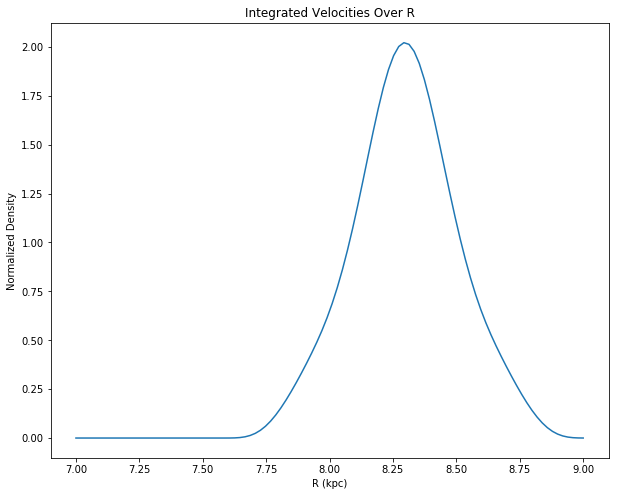

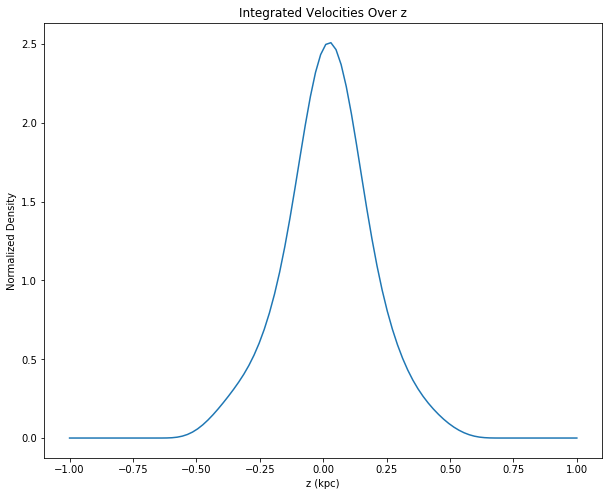

In [8]:
#Plotting densities with varrying R and z and integrated velocities
plt.figure(figsize=(10,8))
plt.plot(R_input, R_output/np.sum(R_output)/(R_input[1] - R_input[0]))
plt.title('Integrated Velocities Over R')
plt.xlabel('R (kpc)')
plt.ylabel('Normalized Density')
plt.savefig('zscore_cyl_integrated_R')
plt.show()

plt.figure(figsize=(10,8))
plt.plot(z_input, z_output/np.sum(z_output)/(z_input[1] - z_input[0]))
plt.title('Integrated Velocities Over z')
plt.xlabel('z (kpc)')
plt.ylabel('Normalized Density')
plt.savefig('zscore_cyl_integrated_z')
plt.show()